# Algorithm: Random Forest
Acknowledgement: Most of the code was referenced from Prof. Mafas Raheem's AML lab-10.1.
## Model Validation Strategy
Three models evaluated with two different datasets as described below (altogether 6 models).
### Standard dataset (without class balancing)
- Base
- Grid-Search-CV
- Random-Search-CV
### Oversampled dataset (with class balancing)
- Base
- Grid-Search-CV
- Random-Search-CV
### Conclusion (for all evaluations)
- accuracy chart

In [33]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

# Warning was disabled to capture errors and warning. Can be enabled when needed.
# warnings.filterwarnings("ignore")

In [34]:
# Load the preprocessed dataset (299 records; with 14 features)
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


# Set Models' Hyperparameters and Cross-Validation Strategy

In [35]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid and random search.
parameters = dict()
# The function to measure the quality of a split
parameters['criterion'] = ['gini', 'entropy']
# Class Weight
parameters['class_weight'] = ['balanced', 'dict']

# Number of trees in random forest
# parameters['n_estimators'] = arange(200, 1000, 200)
parameters['n_estimators'] = arange(200, 250, 50)

# Number of features to consider at every split
parameters['max_features'] = ['auto', 'sqrt']

# Maximum number of levels in tree
parameters['max_depth'] = arange(10, 110, 10)

# Minimum number of samples required to split a node
parameters['min_samples_split'] = [2, 5, 10]

# Minimum number of samples required at each leaf node
parameters['min_samples_leaf'] = [1, 2, 4]

# Method of selecting samples for training each tree
parameters['bootstrap'] = [True, False]

# A stratified K fold for cross-validation strategy - values are assigned from the evaluation helper module.
# When random state is enabled, shuffle has to be enabled to. Shuffle is done before the deterministic split (sklearn doc).
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Dict for storing accuracies and drawing chart in the conclusion section.
ev.accuracies = {}

# Base Model (Function)

In [ ]:
# A function to build base model.
def build_and_validate_base_model(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    rf= RandomForestClassifier(verbose=verbose, random_state=ev.random_state)
    rf.fit(x_train, y_train)

    # Display the hyperparameters used.
    print(f'Params         :{ rf.get_params()}.')

    # Do prediction with the train model.
    y_pred = rf.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, rf)

# Grid Search CV (Function)

In [36]:
# A function discover the model's best hyperparameters and perform cross-validation using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    rf= RandomForestClassifier(verbose=verbose, random_state=ev.random_state)

    # Build Grid-search with parameters and stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(rf, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{grid_scv.best_params_}.')
    print(f'Best score (*mean)  :{grid_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, grid_scv)

# Random Search CV (Function)

In [37]:
# A function discover the model's best hyperparameters and perform cross-validation using RandomSearchCV.
def build_and_validate_with_random_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    rf= RandomForestClassifier(verbose=verbose, random_state=ev.random_state)

    # Build Random-search with parameters and stratified k fold strategy for cross-validation.
    rand_scv = RandomizedSearchCV(rf, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    rand_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{rand_scv.best_params_}.')
    print(f'Best score (*mean)  :{rand_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = rand_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curv and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, rand_scv)

# Evaluation with Standard Dataset (without class balancing)

### Data Preparation

In [ ]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis = 1)
y = data[uci.UCIHeartDiseaseData.target]

# Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
X_train, X_test, Y_train, Y_test = ev.scale_and_split(X, y)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(Y_train)}.')
print(f'Test-set    : {Counter(Y_test)}.')

std_y_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
              ['Train', Counter(Y_train).get(0), Counter(Y_train).get(1)],
              ['Test', Counter(Y_test).get(0), Counter(Y_test).get(1)]]

pd.DataFrame(std_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();


Evaluation name: std-base.
Params         :{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': False, 'warm_start': False}.

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.81      0.79      0.80        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.82        60
weighted avg       0.82      0.82      0.82        60

Actual accuracy result: 81.66666666666667.
Parsed accuracy result: 82.0.

Confusion Matrix


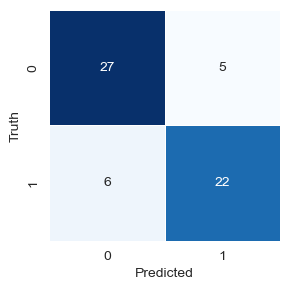

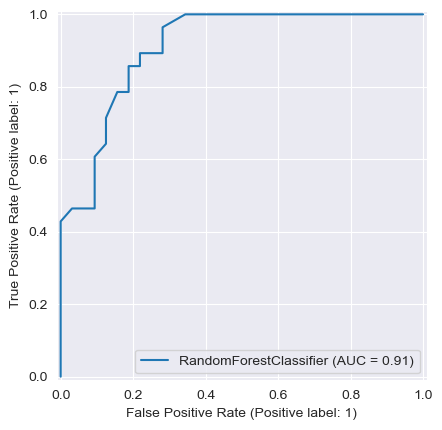

In [38]:
# Evaluation: Standard Base
acc = build_and_validate_base_model(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_base)
ev.accuracies[ev.EvaluationType.std_base] = acc

In [ ]:
# Evaluation: Standard Grid Search CV
acc = build_and_validate_with_grid_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_grid_search_cv)
ev.accuracies[ev.EvaluationType.std_grid_search_cv] = acc


Evaluation name: std-rand-scv.
Best params         :{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}.
Best score (*mean)  :0.8367907801418439.

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.83      0.71      0.77        28

    accuracy                           0.80        60
   macro avg       0.81      0.79      0.80        60
weighted avg       0.80      0.80      0.80        60

Actual accuracy result: 80.0.
Parsed accuracy result: 80.0.

Confusion Matrix


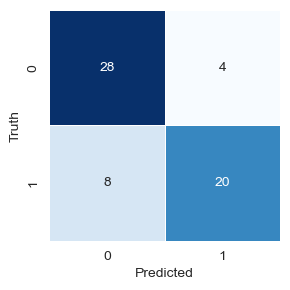

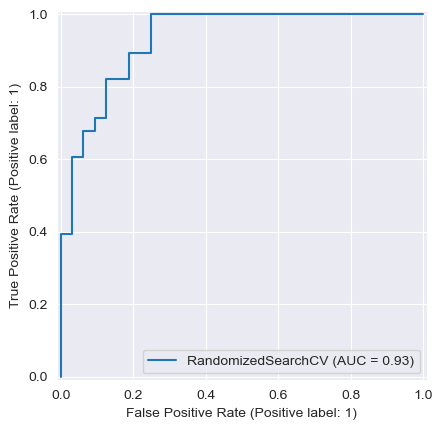

In [39]:
# Evaluation: Standard Random Search CV
acc = build_and_validate_with_random_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_random_search_cv)
ev.accuracies[ev.EvaluationType.std_random_search_cv] = acc

In [40]:
print(f'Accuracies : {ev.accuracies}.')

Accuracies : {'std-base': 82.0, 'std-rand-scv': 80.0}.


# Evaluation with Oversampled Dataset (with class balancing)

### Data Preparation and Oversampling

Class counter (stratified):
Entire-set  : Counter({0: 160, 1: 160}).
Train-set   : Counter({1: 128, 0: 128}).
Test-set    : Counter({1: 32, 0: 32}).


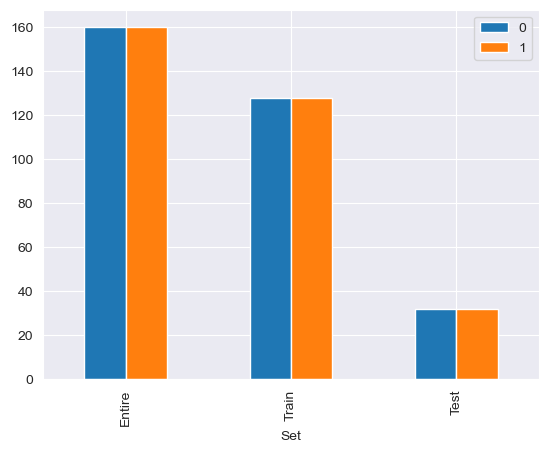

In [41]:
# Prepare features and target variables from original data frame.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE(random_state=ev.random_state).fit_resample(X, y)

# Scale and spit the oversampled data.
Xb_train, Xb_test, Yb_train, Yb_test = ev.scale_and_split(X_b, y_b)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y_b)}.')
print(f'Train-set   : {Counter(Yb_train)}.')
print(f'Test-set    : {Counter(Yb_test)}.')

os_y_data = [['Entire', Counter(y_b).get(0), Counter(y_b).get(1)],
              ['Train', Counter(Yb_train).get(0), Counter(Yb_train).get(1)],
              ['Test', Counter(Yb_test).get(0), Counter(Yb_test).get(1)]]

pd.DataFrame(os_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();

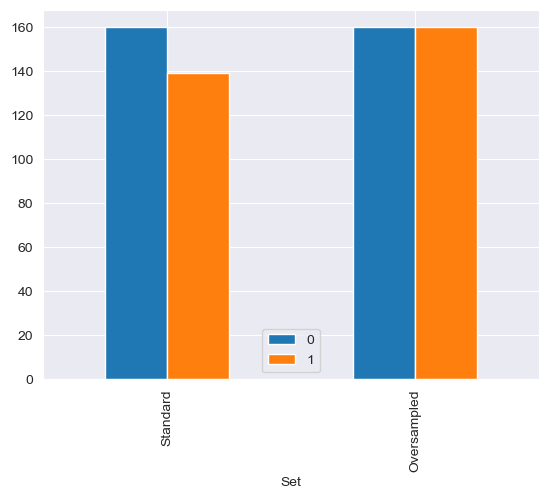

In [42]:
# Before and after oversampling
target_set_data = [['Standard', Counter(y).get(0), Counter(y).get(1)],
                   ['Oversampled', Counter(y_b).get(0), Counter(y_b).get(1)]]

pd.DataFrame(target_set_data, columns=['Set','0','1']).set_index('Set').plot.bar();


Evaluation name: os-base.
Params         :{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': False, 'warm_start': False}.

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.86      0.75      0.80        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64

Actual accuracy result: 81.25.
Parsed accuracy result: 81.0.

Confusion Matrix


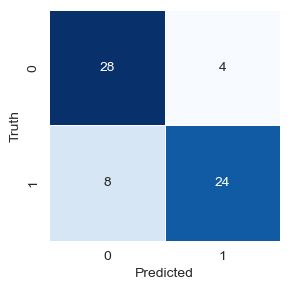

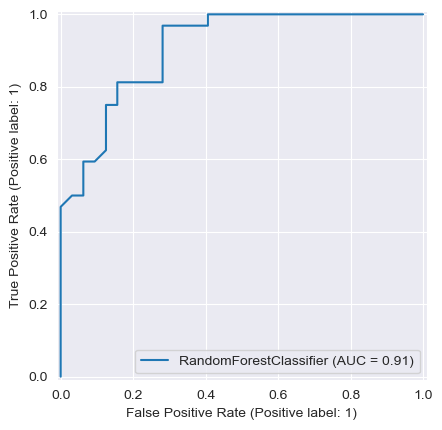

In [43]:
# Evaluation: Over-sampled Base
acc = build_and_validate_base_model(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_base)
ev.accuracies[ev.EvaluationType.os_base] = acc

In [ ]:
# Evaluation: Over-sampled Grid Search CV
acc = build_and_validate_with_grid_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_grid_search_cv)
ev.accuracies[ev.EvaluationType.os_grid_search_cv] = acc


Evaluation name: os-rand-scv.
Best params         :{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}.
Best score (*mean)  :0.839969834087481.

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.91      0.81        32
           1       0.88      0.66      0.75        32

    accuracy                           0.78        64
   macro avg       0.80      0.78      0.78        64
weighted avg       0.80      0.78      0.78        64

Actual accuracy result: 78.125.
Parsed accuracy result: 78.0.

Confusion Matrix


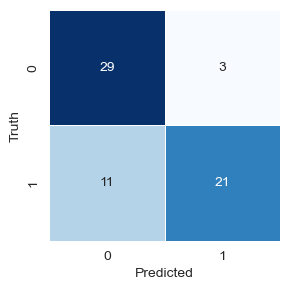

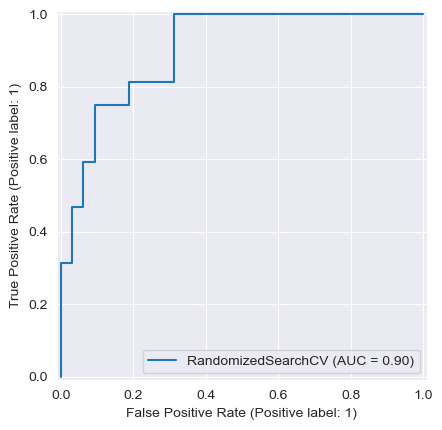

In [46]:
# Evaluation: Over-sampled Random Search CV
acc = build_and_validate_with_random_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_random_search_cv)
ev.accuracies[ev.EvaluationType.os_random_search_cv] = acc

In [47]:
print(f'Accuracies : {ev.accuracies}.')

Accuracies : {'std-base': 82.0, 'std-rand-scv': 80.0, 'os-base': 81.0, 'os-rand-scv': 78.0}.


# Conclusion

In [48]:
# Function to display value on the bar chart.
def add_labels(x_pos, y_pos, delta):
    for i in range(len(x_pos)):
        dist = i + delta
        plt.text(dist, y_pos[i], y_pos[i], ha = 'center')

acc_model_type = ['Base', 'GridCSV', 'RandSCV']
bar_width = 0.35
x = np.arange(len(acc_model_type))

# Bar Plot size
plt.figure(figsize = (7,7))

# Set standard bar type and values.
acc_standard_data = [
    ev.accuracies[ev.EvaluationType.std_base],
    ev.accuracies[ev.EvaluationType.std_grid_search_cv],
    ev.accuracies[ev.EvaluationType.std_random_search_cv]
]
# Set oversampled bar type and values.
acc_oversampled_data = [
    ev.accuracies[ev.EvaluationType.os_base],
    ev.accuracies[ev.EvaluationType.os_grid_search_cv],
    ev.accuracies[ev.EvaluationType.os_random_search_cv]
]
plt.bar(x - bar_width / 2, acc_standard_data, bar_width, label='Standard', color='skyblue')
plt.bar(x + bar_width / 2, acc_oversampled_data, bar_width, label='Oversampled', color='lightgreen')

# Display value on the bar chart.
add_labels(acc_model_type,acc_standard_data,-(bar_width/2))
add_labels(acc_model_type,acc_oversampled_data, bar_width/2)

# Adding labels and title
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylabel('Accuracy (%)')
plt.xticks(x, acc_model_type)
plt.legend(title='Regions', loc='lower right')
plt.show();

# For debugging values.
print(f'Model types             : {acc_model_type}.')
print(f'Standard accuracies     : {acc_standard_data}.')
print(f'Oversampled accuracies  : {acc_oversampled_data}.')
print(f'Accuracies (dict)       : {ev.accuracies}.')

KeyError: 'std-grid-scv'

<Figure size 700x700 with 0 Axes>

In [49]:
# Since, GridSCV perform more extensive cross-validation compared to RandSCV to ensure model's stability, the highest score between
# standard data and oversampled data for GridSCV is selected.
grid_accuracies = [ev.accuracies[ev.EvaluationType.std_grid_search_cv], ev.accuracies[ev.EvaluationType.os_grid_search_cv]]

print(f'Grid accuracies     : {grid_accuracies}.')

# Set the global score for comparisons.
ev.global_accuracies['RF'] = max(grid_accuracies)

print(f'Highest accuracy    : {ev.global_accuracies}.')

KeyError: 'std-grid-scv'